# Building a Spam Filter with Naive Bayes Algorithm from scratch

![spam](spam.jpg)

## Introduction:
In this project, we will use Naive Bayes algorithm for building a spam filter for SMS messages.
To classify messages as spam or non-spam, a computer:
- Learns how humans classify messages.
- Uses that human knowledge to estimate probabilities for new messages — probabilities for spam and non-spam.
- Classifies a new message based on these probability values — if the probability for spam is greater, then it classifies the message as spam. Otherwise, it classifies it as non-spam (if the two probability values are equal, then we may need a human to classify the message).

## Goal:
So our first task is to "teach" the computer how to classify messages. To do that, we'll use the multinomial Naive Bayes algorithm

### Resources:
The dataset was put together by Tiago A. Almeida and José María Gómez Hidalgo, and it can be downloaded from the [The UCI Machine Learning Repository](https://archive.ics.uci.edu/ml/datasets/sms+spam+collection). The data collection process is described in more details on [this page](http://www.dt.fee.unicamp.br/~tiago/smsspamcollection/#composition), where you can also find some of the authors' papers.

---

In [1]:
# Import Libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline 

from wordcloud import WordCloud, STOPWORDS
import re

## Loading and Exploring Data 

In [2]:
data = pd.read_csv('SMSSpamCollection.csv', sep='\t', header=None, names=['Label', 'SMS'])

In [3]:
data.head()

,Label,SMS
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."


- Bear that 'ham' means 'not Spam'

In [4]:
print('The dataset has {} columns and {} rows'.format(data.shape[1], data.shape[0]))

The dataset has 2 columns and 5572 rows


In [5]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5572 entries, 0 to 5571
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   Label   5572 non-null   object
 1   SMS     5572 non-null   object
dtypes: object(2)
memory usage: 87.2+ KB


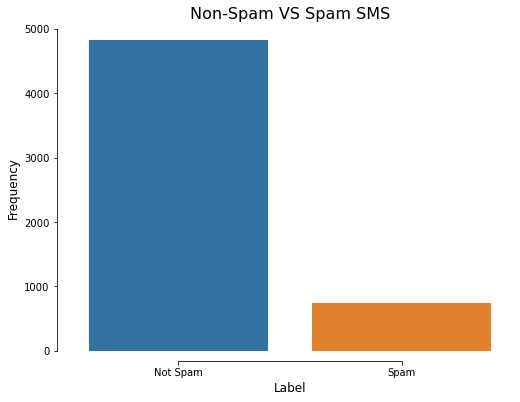

In [6]:
plt.figure(figsize=(8,6))
sns.barplot(x=data['Label'].value_counts().index, y=data['Label'].value_counts(), data=data)

# Settings
plt.xticks([0,1],['Not Spam', 'Spam'])
plt.title('Non-Spam VS Spam SMS', fontsize=16)
plt.ylabel('Frequency', fontsize=12)
plt.xlabel('Label', fontsize=12)

# Aesthetics
sns.despine(offset=10, trim=True)


In [7]:
data['Label'].value_counts(normalize=True)

ham     0.865937
spam    0.134063
Name: Label, dtype: float64

- The dataset has 86.60% **non-spam** and 14.40% **spam** SMSs

---

We're now going to split our dataset into a training and a test set, where the training set accounts for 80% of the data, and the test set for the remaining 20%.


## Splitting the data into Training and Testing Sets

In [8]:
# Randomize the dataset
data_randomized = data.sample(frac=1, random_state=1)

# Calculate index for split
training_test_index = round(len(data_randomized) * 0.8)

# Training/Test split
train_set = data_randomized[:training_test_index].reset_index(drop=True)
test_set = data_randomized[training_test_index:].reset_index(drop=True)

# Print the shapes
print(train_set.shape)
print(test_set.shape)

(4458, 2)
(1114, 2)


Lets make sure that the proportion of non-spam to spam in each of the `train` and `test` is not very different from the parent dataset, `data`

In [9]:
train_set['Label'].value_counts(normalize=True)

ham     0.86541
spam    0.13459
Name: Label, dtype: float64

In [10]:
test_set['Label'].value_counts(normalize=True)

ham     0.868043
spam    0.131957
Name: Label, dtype: float64

- Both look completely fine

---

## Exploration using Word Cloud

In [95]:
def plot_wordcloud(data, column):
    '''
    This functions plots a Word
    Cloud of strings in the given
    column.
    
    Args:
        data: The DataFrame
        column: The Column
    
    Return:
        A beautiful plot of words 
        with their fontsizes related
        to their densities in the
        column.
        
    Acknowledgments:
        'https://www.geeksforgeeks.org/
        generating-word-cloud-python/'
    '''
    comment_words = ''
    stopwords = set(STOPWORDS)

    # iterate through the csv file
    for words in data[column]:

        # typecaste each val to string
        words = str(words)

        # split the value
        tokens = words.split()

        # Converts each token into lowercase
        for i in range(len(tokens)):
            tokens[i] = tokens[i].lower()

        comment_words += " ".join(tokens)+" "

    wordcloud = WordCloud(width = 1200, height = 800,
                    background_color ='white',
                    stopwords = stopwords,
                    min_font_size = 10).generate(comment_words)

    # plot the WordCloud image                      
    plt.figure(figsize = (10, 8), facecolor = None)
    plt.imshow(wordcloud)
    plt.axis("off")
    plt.tight_layout(pad = 0)

    plt.show()

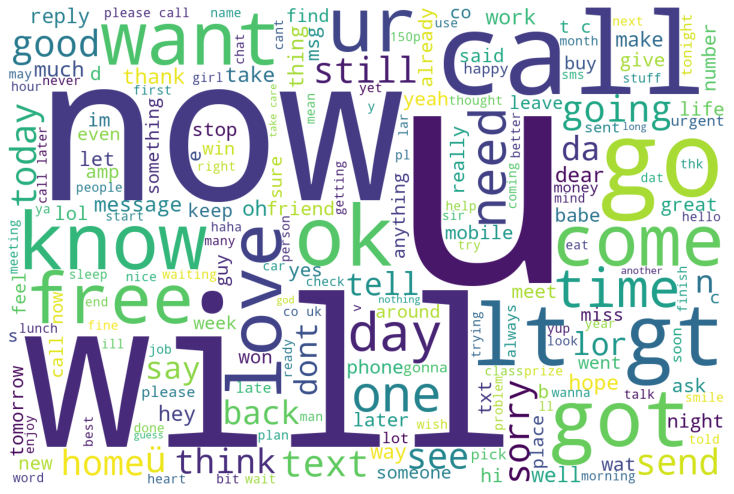

In [96]:
plot_wordcloud(data, 'SMS')

---

## Data Cleaning

For algorithm to work on our dataset, we need to transform our data in a format that will allow us to extract the information easily. This transformation is explained in these **before and after** images 
For now, our data is in this form
![before](smsbefore.png)

And We want to transform it into this form
![after](smsafter.png)


The transformation requires following steps
- The `SMS` column doesn't exist anymore, instead, the `SMS` column is replaced by a series of new columns, where each column represents a unique word from the **vocabulary**.
- Each row describes a single message, with the number of times each word from the vocabulary occurs in it,
- All words in the vocabulary are in lower case,
- Punctuation is not considered anymore.

#### Letter Case and Punctuation

In [11]:
# Remove Punctuation
train_set['SMS'] = train_set['SMS'].str.replace('\W', ' ').str.lower()

# Lower Case all words
train_set['SMS'] = train_set['SMS'].str.lower()

# Peak into the DataFrame after changes
train_set.head()

,Label,SMS
0,ham,yep by the pretty sculpture
1,ham,yes princess are you going to make me moan
2,ham,welp apparently he retired
3,ham,havent
4,ham,i forgot 2 ask ü all smth there s a card on ...


#### Creating a Vocabulary

In [12]:
# Split the strings at commas
train_set['SMS'] = train_set['SMS'].str.split()
train_set.head()

,Label,SMS
0,ham,"[yep, by, the, pretty, sculpture]"
1,ham,"[yes, princess, are, you, going, to, make, me,..."
2,ham,"[welp, apparently, he, retired]"
3,ham,[havent]
4,ham,"[i, forgot, 2, ask, ü, all, smth, there, s, a,..."


In [13]:
# A list to contain all the words
vocabulary = []

# Loop through the SMS column for words and append the list
for sms in train_set['SMS']:
    for word in sms:
        vocabulary.append(word)
    
# Check out the list
print('Number of words in Vocabulary:',len(vocabulary))

# To cancel out the repeatations, convert it into a set and then back to the list
vocabulary = list(set(vocabulary))
print('Number of Unique words in Vocabulary:',len(vocabulary))

Number of words in Vocabulary: 72427
Number of Unique words in Vocabulary: 7783


For the transformation, we're going to create a new DataFrame. However, we'll first build a **dictionary** that we'll then convert to the DataFrame we need.

In [14]:
word_counts_per_sms = {unique_word: [0] * len(train_set['SMS']) for unique_word in vocabulary}

for index, sms in enumerate(train_set['SMS']):
    for word in sms:
        word_counts_per_sms[word][index] += 1

In [15]:
# Dictionary to DataFrame
word_counts = pd.DataFrame(word_counts_per_sms)
word_counts.head()

,pro,textbuddy,aka,jog,domain,repent,should,endowed,madstini,whoever,...,dress,2morow,whens,lemme,behind,dartboard,news,pleasant,u,canal
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [16]:
# Join this new DataFrame with the one with Labels (original one)
train_set_clean = pd.concat([train_set, word_counts], axis=1)
train_set_clean.head()

,Label,SMS,pro,textbuddy,aka,jog,domain,repent,should,endowed,...,dress,2morow,whens,lemme,behind,dartboard,news,pleasant,u,canal
0,ham,"[yep, by, the, pretty, sculpture]",0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,ham,"[yes, princess, are, you, going, to, make, me,...",0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,ham,"[welp, apparently, he, retired]",0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,ham,[havent],0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,ham,"[i, forgot, 2, ask, ü, all, smth, there, s, a,...",0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [27]:
# # Creating a word cloud
# fig = plt.subplots(figsize=(12,10)) 
# wordcloud = WordCloud(width=1000, height=700,
#                       background_color='white', 
#                       random_state=1).generate_from_frequencies(filtered_sorted_spam_dict)
# plt.title('The most frequent words in spam messages\n', fontsize=29)
# plt.imshow(wordcloud)
# plt.axis('off')
# plt.show()

---

Now that we're done with data cleaning and have a training set to work with, we can begin creating the spam filter. The Naive Bayes algorithm will need to know the probability values of the two equations below to be able to classify new messages:
\begin{equation}
P(Spam | w_1,w_2, ..., w_n) \propto P(Spam) \cdot \prod_{i=1}^{n}P(w_i|Spam) \\
P(Ham | w_1,w_2, ..., w_n) \propto P(Ham) \cdot \prod_{i=1}^{n}P(w_i|Ham)
\end{equation}

Also, to calculate $P(w\tiny(i)$$|Spam)$ and $P(w\tiny(i)$$|Ham)$ inside the formulas above, recall that we need to use these equations:
\begin{equation}
P(w_i|Spam) = \frac{N_{w_i|Spam} + \alpha}{N_{Spam} + \alpha \cdot N_{Vocabulary}} \\
P(w_i|Ham) = \frac{N_{w_i|Ham} + \alpha}{N_{Ham} + \alpha \cdot N_{Vocabulary}}
\end{equation}

### Calculating `Constants`

Some of the terms in the four equations above will have the same value for every new message, i-e, they are `constants`. As a start, let's first calculate the `constants`:

- $P\tiny Spam$ and $P\tiny Ham$
- $N\tiny Spam$, $N\tiny Ham$, $N\tiny Vocabulary$

Recall that:

- **NSpam** is equal to the number of words in all the spam messages — it's not equal to the number of spam messages, and it's not equal to the total number of unique words in spam messages.
- **NHam** is equal to the number of words in all the non-spam messages — it's not equal to the number of non-spam messages, and it's not equal to the total number of unique words in non-spam messages.

We will also use Laplace smoothing and set $\alpha = 1$

<font color='grey'>Laplace smoothing is a technique used to smooth categorical data. Ihelps tackle the problem of zero probability in the Naïve Bayes machine learning algorithm. 

In [28]:
# Isolate Spam and Ham SMSs first
spam_sms = train_set_clean[train_set_clean['Label'] == 'spam']
ham_sms = train_set_clean[train_set_clean['Label'] == 'ham']

# Calculate Probability of each 
p_spam = len(spam_sms) / len(train_set_clean)
p_ham = len(ham_sms) / len(train_set_clean)

# N_spam
n_words_per_spam_sms = spam_sms['SMS'].apply(len)
n_spam = n_words_per_spam_sms.sum()

# N_ham
n_words_per_ham_sms = ham_sms['SMS'].apply(len)
n_ham = n_words_per_ham_sms.sum()

# N_vocabulary
n_vocabulary = len(vocabulary)

# Laplace smoothing
alpha = 1

### Calculating `Parameters`

Now that we have the `constant` terms calculated above, we can move on with calculating the `parameters` $P(w_i|Spam)$ and $P(w_i|Ham)$. Each `parameter` will thus be a conditional probability value associated with each word in the vocabulary.

The `parameters` are calculated using the formulas:

\begin{equation}
P(w_i|Spam) = \frac{N_{w_i|Spam} + \alpha}{N_{Spam} + \alpha \cdot N_{Vocabulary}}
\end{equation}

\begin{equation}
P(w_i|Ham) = \frac{N_{w_i|Ham} + \alpha}{N_{Ham} + \alpha \cdot N_{Vocabulary}}
\end{equation}

In [29]:
# Dictionaries to contain probabilities
p_wi_spam = {} 
p_wi_ham = {}

for word in vocabulary:
    n_word_given_spam = spam_sms[word].sum()   
    p_word_given_spam = (n_word_given_spam + alpha) / (n_spam + alpha*n_vocabulary)
    p_wi_spam[word] = p_word_given_spam
    
    n_word_given_ham = ham_sms[word].sum()   
    p_word_given_ham = (n_word_given_ham + alpha) / (n_ham + alpha*n_vocabulary)
    p_wi_ham[word] = p_word_given_ham

Now that we've calculated all the `constants` and `parameters` we need, we can start creating the spam filter. The spam filter can be understood as a function that:
- Takes in as input a new message $(w_1, w_2, ..., w_n)$


- Calculates $P(Spam|w_1, w_2, ..., w_n)$ and $P(Ham|w_1, w_2, ..., w_n)$


- Compares the values of $P(Spam|w_1, w_2, ..., w_n)$ and $P(Ham|w_1, w_2, ..., w_n)$, and:

    - If $P(Ham|w_1, w_2, ..., w_n) > P(Spam|w_1, w_2, ..., w_n)$, then the message is classified as **ham**.
    
    - If $P(Ham|w_1, w_2, ..., w_n) < P(Spam|w_1, w_2, ..., w_n)$, then the message is classified as **spam**.
    
    - If $P(Ham|w_1, w_2, ..., w_n) = P(Spam|w_1, w_2, ..., w_n)$, then the algorithm may **request human help**.

---

Lets try to determine how well the spam filter does on our test set of 1,114 messages.
## Testing the Spam Filter

In [30]:
def classify(message):
    '''
    This functions classifies a SMS to be 
    a spam, non-spam (ham), or in cases 
    where it is not able to classify, it
    asks for human assistance
    
    Args:
        message: str. SMS
        
    Returns:
        ham, spam, or require human assistance
    '''

    # Clean the message
    message = re.sub('\W', ' ', message)
    message = message.lower().split() # Chain String methods
    
    # Probabilities
    p_spam_given_message = p_spam
    p_ham_given_message = p_ham
    
    # Iterates the message
    for word in message:
        if word in p_wi_spam:
            p_spam_given_message *= p_wi_spam[word]
        if word in p_wi_ham:
            p_ham_given_message *= p_wi_ham[word]
    
    # Compares the probabilities and returns 
    if p_ham_given_message > p_spam_given_message:
        return 'ham'
    elif p_ham_given_message < p_spam_given_message:
        return 'spam'
    else:
        return 'Equal proabilities, have a human classify this!'

In [31]:
# Lets test the function classify()
print(classify('WINNER!! This is the secret code to unlock the money: C3421.'))
print(classify("Sounds good, Tom, then see u there"))

spam
ham


- The classifier worked successfully on two messages

Lets check its performance on our **test set**

In [32]:
test_set['Predicted'] = test_set['SMS'].apply(classify)
test_set.head()

,Label,SMS,Predicted
0,ham,Later i guess. I needa do mcat study too.,ham
1,ham,But i haf enuff space got like 4 mb...,ham
2,spam,Had your mobile 10 mths? Update to latest Oran...,spam
3,ham,All sounds good. Fingers . Makes it difficult ...,ham
4,ham,"All done, all handed in. Don't know if mega sh...",ham


Lets use a very simple metric called **Accuracy** to measure the performance of our Spam Filter

\begin{equation}
\text{Accuracy} = \frac{\text{number of correctly classified messages}}{\text{total number of classified messages}}
\end{equation}


In [33]:
correct = 0
total = test_set.shape[0]

for row in test_set.iterrows():
    row = row[1]
    if row['Label'] == row['Predicted']: 
        correct += 1

print('Correct responses, out of {}, are {}'.format(total, correct))
print('Wrong responses, out of {}, are {}'.format(total, total-correct))
print('-'*40)

# Accuracy
accuracy = correct/total
print('Accuracy of the Spam Filter:', round(accuracy, 4))

Correct responses, out of 1114, are 1100
Wrong responses, out of 1114, are 14
----------------------------------------
Accuracy of the Spam Filter: 0.9874


- We managed to build a spam filter for SMS messages using the multinomial Naive Bayes algorithm. The filter had an accuracy of 98.74% on the test set, which is an **excellent result**. We initially aimed for an accuracy of over 80%, but we managed to do way better than that.



#### Although our accuracy is excellent, it is worthwhile to check the wrong responses of our Spam Filter

In [50]:
# Condition: ham are predicted incorrectly
false_ham = (test_set['Label'] == 'ham') & (test_set['Predicted'] == 'spam') 

# Condition:spam are predicted incorrectly
false_spam = (test_set['Label'] == 'spam') & (test_set['Predicted'] == 'ham') 

false_results = test_set[false_ham | false_spam]

In [74]:
false_results = false_results.reset_index(drop=True) # Dropping the ambiguous index

# Sort the results in an order
false_results = false_results.sort_values(by='Predicted')

In [75]:
# Lets look each SMS closely
for row in false_results.iterrows():
    print('This {} message was marked INCORRECTLY as {}:\n\n{}\n{}'.format(row[1]['Label'],row[1]['Predicted'],row[1]['SMS'],('-'*120)))

This spam message was marked INCORRECTLY as ham:

Not heard from U4 a while. Call me now am here all night with just my knickers on. Make me beg for it like U did last time 01223585236 XX Luv Nikiyu4.net
------------------------------------------------------------------------------------------------------------------------
This spam message was marked INCORRECTLY as ham:

More people are dogging in your area now. Call 09090204448 and join like minded guys. Why not arrange 1 yourself. There's 1 this evening. A£1.50 minAPN LS278BB
------------------------------------------------------------------------------------------------------------------------
This spam message was marked INCORRECTLY as ham:

Oh my god! I've found your number again! I'm so glad, text me back xafter this msgs cst std ntwk chg £1.50
------------------------------------------------------------------------------------------------------------------------
This spam message was marked INCORRECTLY as ham:

Hi babe its Chlo

## A closer look at the Word densities of the function where the Filter predicted <font color ='red'> **incorrectly**

### Word Cloud of sms predicted incorrectly as `ham`

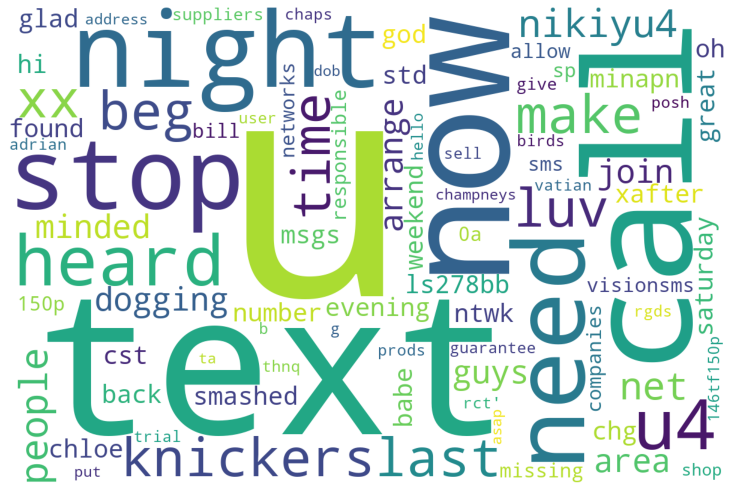

In [116]:
plot_wordcloud(false_results[false_results['Predicted'] == 'ham'],'SMS')

### Word Cloud of sms predicted incorrectly as `spam`

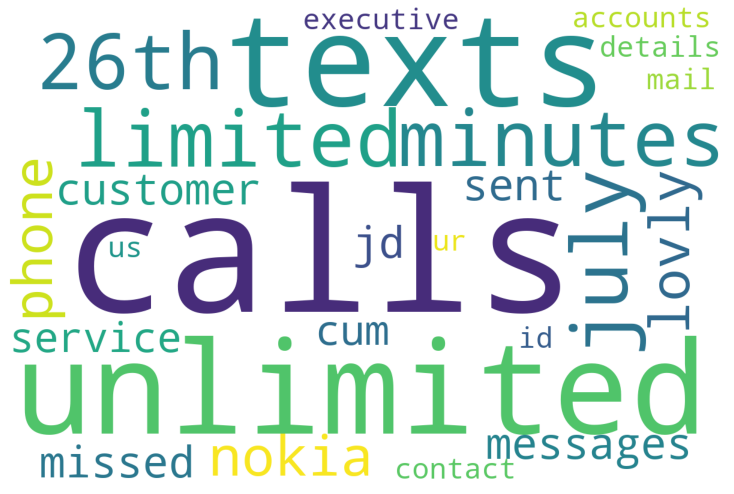

In [117]:
plot_wordcloud(false_results[false_results['Predicted'] == 'spam'],'SMS')

#### Observations:
- We can see that mostly, short lenghted messages were **incorrectly** predicted as **spam**. Words like 'Unlimited', 'calls',  'Customer', 'Contact us'. and interestingly, '26th' could have garnered the unwanted attention
- Messages those are **incorrectly** predicted as **not spam** look like well crafted messages that are relatively longer and contain some context in them. The words in context might would had let them stay safe from filter's attention. We can also witness some 'internet lingo' that might helped the message to evade the filteration system.


## Conclusion:
In this project, we created Spam Filter based on the Naive Bayes algorithm. The spam filter takes in a new message and classifies it as spam or ham. The Spam Filter proved to be highly accurate on the dataset of 5,572 labelled SMSs having reached an accuracy of 98.74%.